In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import sys
import os
import torch
from legoml.utils.summary import summarize_model

In [69]:
from experiments.image_clf.config import Config
from experiments.image_clf.data import get_dls
from experiments.image_clf.models import CNN__MLP_tiny_28x28

In [70]:
from legoml.utils.logging import get_logger
from legoml.utils.seed import set_seed

In [71]:
import matplotlib.pyplot as plt

%matplotlib inline

In [72]:
device = torch.device("mps")
set_seed(42)
config = Config(max_epochs=1, data_root="../../raw_data/")

In [73]:
model = CNN__MLP_tiny_28x28()

In [74]:
model

CNN__MLP_tiny_28x28(
  (0): Conv_3x3__BnAct__Pool(
    (0): Conv_3x3__BnAct(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  )
  (1): Conv_3x3__BnAct(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (2): Conv_3x3__BnAct__Pool(
    (0): Conv_3x3__BnAct(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  )
  (3): Conv_3x3__BnAct(
    (0

In [75]:
from legoml.core.context import Context
from legoml.callbacks.checkpoint import CheckpointCallback

eval_context = Context(
    config=config,
    model=model,
    loss_fn=torch.nn.CrossEntropyLoss(),
    device=device,
)

checkpoint_path = "../../runs/train_img_clf/run_20250824_183653/artifacts/checkpoints/ckpt_last.pt"
_ = CheckpointCallback.load_into(
    context=eval_context,
    path=checkpoint_path,
    map_location=device.type,
)


In [76]:
train_dl, eval_dl = get_dls(config)

2025-08-24 19:44:53 [info     ] Created data loaders           train_size=938 val_size=313


In [77]:
single_batch = next(iter(eval_dl))

In [80]:
images, targets = single_batch.inputs, single_batch.targets

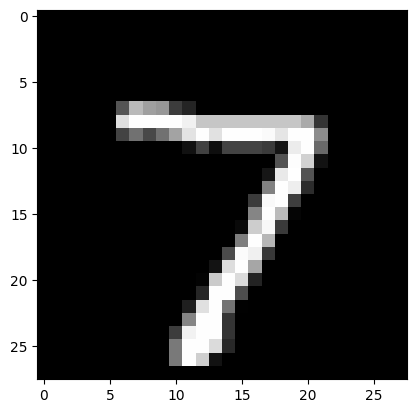

In [81]:
plt.imshow(images[0].reshape((28, 28, 1)), cmap="gray")
plt.show();

In [82]:
targets[0].item()

7

## Model outputs

In [83]:
next(eval_context.model.parameters()).device

device(type='cpu')

In [84]:
images[0].shape

torch.Size([1, 28, 28])

In [85]:
torchsummary.summary(eval_context.model.cpu(), images[0].shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             288
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
         MaxPool2d-4           [-1, 32, 14, 14]               0
            Conv2d-5           [-1, 32, 14, 14]           9,216
       BatchNorm2d-6           [-1, 32, 14, 14]              64
              ReLU-7           [-1, 32, 14, 14]               0
            Conv2d-8           [-1, 64, 14, 14]          18,432
       BatchNorm2d-9           [-1, 64, 14, 14]             128
             ReLU-10           [-1, 64, 14, 14]               0
        MaxPool2d-11             [-1, 64, 7, 7]               0
           Conv2d-12             [-1, 64, 7, 7]          36,864
      BatchNorm2d-13             [-1, 64, 7, 7]             128
             ReLU-14             [-1, 6

In [86]:
_ = eval_context.model.to(device).eval()
with torch.no_grad():
    model_op = eval_context.model(images.to(device))

In [87]:
for idx in range(len(targets))[:5]:
    pred = model_op[idx].argmax(dim=-1).item()
    tgt = targets[idx].item()
    print(f"Pred: {pred}, target: {tgt}")

Pred: 7, target: 7
Pred: 2, target: 2
Pred: 1, target: 1
Pred: 0, target: 0
Pred: 4, target: 4


In [112]:
from collections import OrderedDict

class TestModel(torch.nn.Sequential):
    def __init__(self):
        super().__init__(
            OrderedDict([
                ('fc1', torch.nn.Linear(2, 10)),
                ('activation', torch.nn.ReLU(inplace=True)),
                ('fc2', torch.nn.Linear(10, 2))
            ])
        )

In [113]:
md = TestModel()

In [114]:
md.fc1

Linear(in_features=2, out_features=10, bias=True)

In [116]:
md

TestModel(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (activation): ReLU(inplace=True)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
)

In [118]:
import torch.nn as nn

In [121]:
class AEBackbone__MLP(nn.Sequential):
    def __init__(self, encoder: nn.Module):
        super().__init__(
            OrderedDict(
                [
                    ("encoder", encoder),
                    ("head", nn.Linear(128, 10)),  # [10]
                ]
            )
        )

In [122]:
aemlp = AEBackbone__MLP(md)

In [124]:
aemlp.encoder

TestModel(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (activation): ReLU(inplace=True)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
)

In [13]:
import torch
import torch.nn as nn
from collections import OrderedDict

In [20]:
class NormAct(nn.Module):
    def __init__(self, norm: nn.Module, act: nn.Module):
        super().__init__()
        self.norm = norm
        self.act = act

    def forward(self, x: torch.Tensor): return self.act(self.norm(x))

In [73]:
class ConvLayer(nn.Module):
    def __init__(self, c1, c2, norm_fn, act_fn):
        super().__init__()
        self.norm = norm_fn(c2)
        self.act = act_fn()
        self.conv = nn.Conv2d(c1, c2, 3, 1, 1)
        layers = [self.conv, NormAct(norm=self.norm, act=self.act)]
        self.inner = nn.Sequential(*layers)

    def forward(self, x):
        return self.inner(x)

In [74]:
cv = ConvLayer(3, 16, norm_fn=nn.BatchNorm2d, act_fn=nn.ReLU)

In [75]:
cv

ConvLayer(
  (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): ReLU()
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (inner): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): NormAct(
      (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
    )
  )
)

In [76]:
cv.act = nn.ReLU6()

In [77]:
cv

ConvLayer(
  (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): ReLU6()
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (inner): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): NormAct(
      (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
    )
  )
)

In [44]:
cv.norm

BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [49]:
cv

ConvLayer(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): ReLU6()
)

In [52]:
cv.conv = nn.Conv2d(cv.conv.in_channels, 32, cv.conv.kernel_size)

In [53]:
cv

ConvLayer(
  (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): ReLU6()
)

In [59]:
from typing import Optional

In [60]:
class NormActConv(nn.Sequential):
    """A Sequential layer composed by a normalization, an activation and a convolution layer. This is usually known as a 'Preactivation Block'

    Args:
        in_features (int): Number of input features
        out_features (int): Number of output features
        conv (nn.Module, optional): [description]. Defaults to Conv2dPad.
        normalization (nn.Module, optional): [description]. Defaults to nn.BatchNorm2d.
        activation (nn.Module, optional): [description]. Defaults to nn.ReLU.
    """

    def __init__(
        self,
        in_features: int,
        out_features: int,
        conv: nn.Module = nn.Identity,
        normalization: Optional[nn.Module] = nn.BatchNorm2d,
        activation: Optional[nn.Module] = nn.ReLU,
        *args,
        **kwargs
    ):
        super().__init__()
        if normalization:
            self.add_module("norm", normalization(in_features))
        if activation:
            self.add_module("act", activation())
        self.add_module("conv", conv(in_features, out_features, *args, **kwargs))

In [61]:
nac = NormActConv(3, 8)

In [62]:
nac.norm

BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [65]:
nn.Sequential(*[None])

Sequential(
  (0): None
)

In [59]:
x = torch.rand(4, 64, 32, 32)

In [60]:
x.shape

torch.Size([4, 64, 32, 32])

In [61]:
from legoml.nn.blocks.resnet import Res2Block

In [62]:
blk = Res2Block(c1=64)

In [67]:
splits = x.split(16, dim=1)
shortcut_split, rest = splits[0], splits[1:]

In [68]:
shortcut_split.shape

torch.Size([4, 16, 32, 32])

In [69]:
blk

Res2Block(
  (shortcut): Identity()
  (blocks): ModuleList(
    (0-3): 4 x ConvNormAct(
      (block): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace=True)
      (dropout): Identity()
    )
  )
)

In [70]:
x.shape

torch.Size([4, 64, 32, 32])

In [71]:
print(summarize_model(blk, example_input=x, print_result=False))

------------------------------------------------------------------
Name     | Type       | Params | In              | Out            
------------------------------------------------------------------
shortcut | Identity   | 0      | [4, 16, 32, 32] | [4, 16, 32, 32]
blocks   | ModuleList | 9.3 K  | ?               | ?              
------------------------------------------------------------------
9.3 K          Trainable params
0              Non-trainable params
9.3 K          Total params
0.036          Total estimated parameter size (MiB)


In [72]:
blk(x).shape

torch.Size([4, 64, 32, 32])

In [73]:
x.shape

torch.Size([4, 64, 32, 32])

In [74]:
splits = x.split(4, dim=1)
rest, shortcut_split = splits[:-1], splits[-1]

In [82]:
splits[:16][0].shape

torch.Size([4, 4, 32, 32])

In [77]:
len(rest)

15

In [79]:
shortcut_split.shape

torch.Size([4, 4, 32, 32])

In [83]:
import torch
import torch.nn as nn

class MySequentialWrong(nn.Sequential):
    def __init__(self, c1, c2, c3):
        # Initialize an EMPTY sequential container
        super().__init__()
        
        # These lines REGISTER the layers as submodules...
        self.layer1 = nn.Linear(c1, c2)
        self.layer2 = nn.Linear(c2, c3)
        # ...but they DO NOT add them to the sequential execution path.

# Let's test it
model_wrong = MySequentialWrong(10, 20, 5)
test_tensor = torch.randn(1, 10)
output = model_wrong(test_tensor)

print(f"Input shape:  {test_tensor.shape}")
print(f"Output shape: {output.shape}")

Input shape:  torch.Size([1, 10])
Output shape: torch.Size([1, 5])


## testing res2net

In [128]:
import torch
import torch.nn as nn
import math

# The Bottle2neck block is unchanged from your original code.
class Bottle2neck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, baseWidth=26, scale = 4, stype='normal'):
        """ Constructor
        Args:
            inplanes: input channel dimensionality
            planes: output channel dimensionality
            stride: conv stride. Replaces pooling layer.
            downsample: None when stride = 1
            baseWidth: basic width of conv3x3
            scale: number of scale.
            stype: 'normal': normal set. 'stage': first block of a new stage.
        """
        super(Bottle2neck, self).__init__()

        width = int(math.floor(planes * (baseWidth/64.0)))
        self.conv1 = nn.Conv2d(inplanes, width*scale, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(width*scale)
        
        if scale == 1:
            self.nums = 1
        else:
            self.nums = scale -1
        if stype == 'stage':
            self.pool = nn.AvgPool2d(kernel_size=3, stride = stride, padding=1)
        convs = []
        bns = []
        for i in range(self.nums):
            convs.append(nn.Conv2d(width, width, kernel_size=3, stride = stride, padding=1, bias=False))
            bns.append(nn.BatchNorm2d(width))
        self.convs = nn.ModuleList(convs)
        self.bns = nn.ModuleList(bns)

        self.conv3 = nn.Conv2d(width*scale, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stype = stype
        self.scale = scale
        self.width  = width

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        spx = torch.split(out, self.width, 1)
        for i in range(self.nums):
          if i==0 or self.stype=='stage':
            sp = spx[i]
          else:
            sp = sp + spx[i]
          sp = self.convs[i](sp)
          sp = self.relu(self.bns[i](sp))
          if i==0:
            out = sp
          else:
            out = torch.cat((out, sp), 1)
        if self.scale != 1 and self.stype=='normal':
          out = torch.cat((out, spx[self.nums]),1)
        elif self.scale != 1 and self.stype=='stage':
          out = torch.cat((out, self.pool(spx[self.nums])),1)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

# The new "tiny" Res2Net model for CIFAR-10
class TinyRes2NetCIFAR(nn.Module):
    def __init__(self, block, layers, baseWidth=26, scale=4, num_classes=10):
        self.inplanes = 64
        super(TinyRes2NetCIFAR, self).__init__()
        self.baseWidth = baseWidth
        self.scale = scale
        
        # 1. Modified Input Stem for 32x32 images
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        # Removed the initial MaxPool layer

        # 2. Reduced Depth and Width
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        # Layer 4 is removed

        self.avgpool = nn.AdaptiveAvgPool2d(1)
        
        # 3. Adjusted Classifier for 10 classes
        # The input features now correspond to the output of layer3
        self.fc = nn.Linear(256 * block.expansion, num_classes)

        # Weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample=downsample, 
                            stype='stage', baseWidth=self.baseWidth, scale=self.scale))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, baseWidth=self.baseWidth, scale=self.scale))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # No maxpool layer here
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        # No layer4 here

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

def res2net_cifar_tiny():
    """
    Constructs a tiny Res2Net model for CIFAR-10.
    Using a layer configuration of [2, 2, 2] which makes it a Res2Net-17 like model.
    """
    return TinyRes2NetCIFAR(Bottle2neck, [2, 2, 2])

In [129]:
mdl = res2net_cifar_tiny()

In [130]:
print(summarize_model(mdl, torch.rand(4, 3, 32, 32), depth=2, print_result=False))

----------------------------------------------------------------------------
Name     | Type              | Params  | In               | Out             
----------------------------------------------------------------------------
conv1    | Conv2d            | 1.7 K   | [4, 3, 32, 32]   | [4, 64, 32, 32] 
bn1      | BatchNorm2d       | 128     | [4, 64, 32, 32]  | [4, 64, 32, 32] 
relu     | ReLU              | 0       | [4, 64, 32, 32]  | [4, 64, 32, 32] 
layer1   | Sequential        | 141.7 K | [4, 64, 32, 32]  | [4, 256, 32, 32]
layer1.0 | Bottle2neck       | 69.3 K  | [4, 64, 32, 32]  | [4, 256, 32, 32]
layer1.1 | Bottle2neck       | 72.4 K  | [4, 256, 32, 32] | [4, 256, 32, 32]
layer2   | Sequential        | 654.4 K | [4, 256, 32, 32] | [4, 512, 16, 16]
layer2.0 | Bottle2neck       | 366.6 K | [4, 256, 32, 32] | [4, 512, 16, 16]
layer2.1 | Bottle2neck       | 287.8 K | [4, 512, 16, 16] | [4, 512, 16, 16]
layer3   | Sequential        | 2.6 M   | [4, 512, 16, 16] | [4, 1024, 8, 8] 

In [134]:
mdl

TinyRes2NetCIFAR(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): Bottle2neck(
      (conv1): Conv2d(64, 104, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(104, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pool): AvgPool2d(kernel_size=3, stride=1, padding=1)
      (convs): ModuleList(
        (0-2): 3 x Conv2d(26, 26, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (bns): ModuleList(
        (0-2): 3 x BatchNorm2d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv3): Conv2d(104, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequenti

In [133]:
from dataclasses import asdict
from pathlib import Path

import torch
import torch.optim.lr_scheduler as lrs
from torch.utils.data.dataloader import DataLoader

from experiments.data_utils import create_dataloaders
from experiments.image_clf.config import Config
from experiments.image_clf.steps import eval_step, train_step
from legoml.callbacks.checkpoint import CheckpointCallback
from legoml.callbacks.eval import EvalOnEpochEndCallback
from legoml.callbacks.metric import MetricsCallback
from legoml.core.context import Context
from legoml.core.engine import Engine
from legoml.metrics.multiclass import MultiClassAccuracy
from legoml.utils.log import get_logger
from legoml.utils.seed import set_seed
from legoml.utils.summary import summarize_model
from legoml.utils.track import run

logger = get_logger(__name__)
device = torch.device("mps")
set_seed(42)
config = Config(train_augmentation=True, max_epochs=30, data_root="../../raw_data/")


def build_optim_and_sched(
    config: Config,
    model: torch.nn.Module,
    train_dl: DataLoader,
) -> tuple[torch.optim.Optimizer, lrs.LRScheduler]:
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=1e-6,
        weight_decay=0.0005,
    )
    scheduler = lrs.OneCycleLR(
        optimizer,
        epochs=config.max_epochs,
        steps_per_epoch=len(train_dl),
        max_lr=1e-2,
    )
    return optimizer, scheduler


train_dl, eval_dl = create_dataloaders("cifar10", config, "classification")
model = mdl
optim, sched = build_optim_and_sched(config, model, train_dl)

with run(base_dir=Path("runs").joinpath("train_img_clf_cifar10")) as sess:
    train_context = Context(
        config=config,
        model=model,
        loss_fn=torch.nn.CrossEntropyLoss(),
        optimizer=optim,
        scheduler=sched,
        device=device,
        # scaler=torch.GradScaler(device=device.type),  # slow on M1 air
    )
    trainer = Engine(train_step, train_context)

    eval_context = Context(
        config=config,
        model=model,
        loss_fn=torch.nn.CrossEntropyLoss(),
        device=device,
    )
    evaluator = Engine(
        eval_step,
        eval_context,
        callbacks=[
            MetricsCallback(metrics=[MultiClassAccuracy("eval_acc")]),
        ],
    )

    trainer.callbacks.extend(
        [
            EvalOnEpochEndCallback(evaluator, eval_dl, 1),
            MetricsCallback(metrics=[MultiClassAccuracy("train_acc")]),
            CheckpointCallback(
                dirpath=sess.get_artifact_dir().joinpath("checkpoints"),
                save_every_n_epochs=9999,
                save_on_engine_end=True,
                best_fn=lambda: evaluator.state.metrics["eval_acc"],
            ),
        ]
    )

    summarize_model(model, next(iter(train_dl)).inputs, depth=2)
    model.to(device)
    trainer.loop(train_dl, max_epochs=config.max_epochs)
    sess.log_params({"exp_config": asdict(config)})
    sess.log_text("model", str(model))
    sess.log_params({"trainer": trainer.to_dict()})
    sess.log_params({"evaluator": evaluator.to_dict()})

2025-09-03T13:17:34.584921Z [info     ] Using transforms: [RandomResizedCrop(p=0.5, area_for_downscale=None, interpolation=1, mask_interpolation=0, ratio=(0.75, 1.3333333333333333), scale=(0.75, 1.0), size=(32, 32)), HorizontalFlip(p=0.5), ShiftScaleRotate(p=0.5, shift_limit_x=(-0.2, 0.2), shift_limit_y=(-0.2, 0.2), scale_limit=(-0.09999999999999998, 0.10000000000000009), rotate_limit=(-10.0, 10.0), interpolation=1, border_mode=0, fill=127.0, fill_mask=0.0, rotate_method='largest_box', mask_interpolation=0), ColorJitter(p=1.0, brightness=(0.8, 1.2), contrast=(0.7, 1.3), hue=(-0.1, 0.1), saturation=(0.8, 1.2)), CoarseDropout(p=0.2, fill=127.0, fill_mask=None, hole_height_range=(8, 12), hole_width_range=(8, 12), num_holes_range=(1, 2)), Normalize(p=1.0, max_pixel_value=255.0, mean=(0.49139968, 0.48215827, 0.44653124), normalization='standard', std=(0.24703233, 0.24348505, 0.26158768)), ToTensorV2(p=1.0, transpose_mask=False)]


/Users/altamkhan/Workspace/private/legoml/.venv/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


2025-09-03T13:17:35.060986Z [info     ] Using transforms: [Normalize(p=1.0, max_pixel_value=255.0, mean=(0.49139968, 0.48215827, 0.44653124), normalization='standard', std=(0.24703233, 0.24348505, 0.26158768)), ToTensorV2(p=1.0, transpose_mask=False)]
2025-09-03T13:17:35.512704Z [info     ] Created CIFAR10 data loaders   task_type=classification train_size=782 val_size=313
2025-09-03T13:17:35.514079Z [info     ] Started experiment session     run_dir=runs/train_img_clf_cifar10/run_20250903_184735 run_name=run_20250903_184735
------------------------------------------------------------------------------
Name     | Type              | Params  | In                | Out              
------------------------------------------------------------------------------
conv1    | Conv2d            | 1.7 K   | [64, 3, 32, 32]   | [64, 64, 32, 32] 
bn1      | BatchNorm2d       | 128     | [64, 64, 32, 32]  | [64, 64, 32, 32] 
relu     | ReLU              | 0       | [64, 64, 32, 32]  | [64, 64, 32, 

In [157]:
3 + 1.1 if False else True

True

In [135]:
from experiments.image_clf.models import Res2NetWide_32x32

In [140]:
dummy_ip = torch.randn(1, 3, 32, 32)
model = Res2NetWide_32x32()
_ = summarize_model(model, dummy_ip, depth=2)

----------------------------------------------------------------------------
Name       | Type            | Params  | In               | Out             
----------------------------------------------------------------------------
stem       | Sequential      | 1.9 K   | [1, 3, 32, 32]   | [1, 64, 32, 32] 
stem.0     | ConvNormAct     | 1.9 K   | [1, 3, 32, 32]   | [1, 64, 32, 32] 
backbone   | Sequential      | 1.3 M   | [1, 64, 32, 32]  | [1, 256, 8, 8]  
backbone.0 | Res2NetBlock    | 9.3 K   | [1, 64, 32, 32]  | [1, 64, 32, 32] 
backbone.1 | Res2NetBlock    | 9.3 K   | [1, 64, 32, 32]  | [1, 64, 32, 32] 
backbone.2 | ResNetBasic     | 230.1 K | [1, 64, 32, 32]  | [1, 128, 16, 16]
backbone.3 | Res2NetBlock    | 27.8 K  | [1, 128, 16, 16] | [1, 128, 16, 16]
backbone.4 | ResNetBasic     | 919.0 K | [1, 128, 16, 16] | [1, 256, 8, 8]  
backbone.5 | Res2NetBlock    | 65.0 K  | [1, 256, 8, 8]   | [1, 256, 8, 8]  
head       | Sequential      | 2.6 K   | [1, 256, 8, 8]   | [1, 10]         

In [159]:
x.shape

torch.Size([4, 64, 32, 32])

In [162]:
x.mean(dim=1, keepdim=True).shape

torch.Size([4, 1, 32, 32])

In [164]:
x.shape

torch.Size([4, 64, 32, 32])

In [171]:
gx = torch.norm(x, p=2, dim=(-1, -2), keepdim=True)

In [172]:
nx = gx / (gx.mean(dim=1, keepdim=True) + 1e-6)


In [173]:
nx.shape

torch.Size([4, 64, 1, 1])

In [ ]:
gx = torch.norm(x, p=2, dim=(1, 2), keepdim=True)
nx = gx / (gx.mean(dim=-1, keepdim=True) + 1e-6)
res = self.gamma * (x * nx) + self.beta + x

In [181]:
x.shape

torch.Size([4, 64, 32, 32])

In [190]:
# Built-in, matches einops exactly
r=4
builtin_out = torch.nn.PixelUnshuffle(r)(x)

In [184]:
# Canonical, zero-copy (when possible)
from einops import rearrange

def space_to_depth_einops(x, r):
    b, c, h, w = x.shape
    assert h % r == 0 and w % r == 0
    return rearrange(x, 'b c (ho r1) (wo r2) -> b (c r1 r2) ho wo', r1=r, r2=r)

# Using Unfold — must re-permute the (kH,kW) factors
import torch
import torch.nn.functional as F

def space_to_depth_unfold(x, r):
    b, c, h, w = x.shape
    assert h % r == 0 and w % r == 0
    y = F.unfold(x, kernel_size=r, stride=r)            # [B, C*r*r, (H/r)*(W/r)]
    y = y.view(b, c, r, r, h // r, w // r)              # make kH,kW explicit
    y = y.permute(0, 1, 4, 5, 2, 3).contiguous()        # (B,C,Ho,Wo,r,r)
    return y.view(b, c * r * r, h // r, w // r)         # (B,C*r*r,Ho,Wo)


In [185]:
ein_out = space_to_depth_einops(x, r)

In [186]:
ein_out.shape

torch.Size([4, 1024, 8, 8])

In [187]:
unfold_out = space_to_depth_unfold(x, r)

In [188]:
unfold_out.shape

torch.Size([4, 1024, 8, 8])

In [191]:
torch.allclose(ein_out, builtin_out)

True

In [192]:
torch.allclose(unfold_out, builtin_out)

False

In [194]:
unfold_out.shape, ein_out.shape

(torch.Size([4, 1024, 8, 8]), torch.Size([4, 1024, 8, 8]))

In [205]:
torch.ones(4).view(1, -1, 1, 1).shape

torch.Size([1, 4, 1, 1])

In [206]:
torch.full((1, 4, 1, 1), 0.5).shape

torch.Size([1, 4, 1, 1])

In [207]:
x = torch.rand(1, 3, 32, 32)

In [208]:
from legoml.nn.ops import SpaceToDepth

In [214]:
s2d = SpaceToDepth(4)

In [215]:
s2d(x).shape

torch.Size([1, 48, 8, 8])

## lrs

In [31]:
# warmup_anneal_then_plateau.py
from __future__ import annotations
import math
from typing import Iterable, List, Optional, Union
import torch
from torch.optim import Optimizer

class WarmupAnnealThenPlateau:
    """
    Two-phase LR schedule:
      A) Per-step:
         - Warmup:   start_lr -> max_lr over (pct_start * total_steps) [linear]
         - Anneal:   max_lr   -> base_lr over remaining steps [cos or linear]

    Usage (per *batch* call .step(); per *epoch* call .step_plateau(val_metric)):
        sched = WarmupAnnealThenPlateau(
            optimizer,
            total_epochs=30, steps_per_epoch=len(train_dl),
            pct_start=0.1,
            start_lr=1e-3, max_lr=0.1, base_lr=1e-2,
            anneal_strategy="cos",       # "cos" or "linear"
            plateau_mode="min",          # "min" for loss, "max" for accuracy
            plateau_factor=0.5,
            plateau_patience=2,
            plateau_cooldown=0,
            plateau_min_lr=1e-6,
        )

        for epoch in range(num_epochs):
            model.train()
            for batch in train_loader:
                loss = ...
                loss.backward()
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
                sched.step()              # <-- per-batch

            model.eval()
            val_loss = evaluate(...)
            sched.step_plateau(val_loss) # <-- per-epoch (only matters in plateau phase)
    """

    def __init__(
        self,
        optimizer: Optimizer,
        total_steps: Optional[int] = None,
        *,
        total_epochs: Optional[int] = None,
        steps_per_epoch: Optional[int] = None,
        pct_start: float = 0.1,
        start_lr: Optional[Union[float, List[float]]] = None,
        max_lr: Optional[Union[float, List[float]]] = None,
        base_lr: Optional[Union[float, List[float]]] = None,
        anneal_strategy: str = "cos",  # "cos" or "linear"
        plateau_mode: str = "min",
        plateau_factor: float = 0.5,
        plateau_patience: int = 2,
        plateau_threshold: float = 1e-4,
        plateau_cooldown: int = 0,
        plateau_min_lr: Union[float, List[float]] = 0.0,
        eps: float = 1e-8,
    ):
        if total_steps is None:
            if total_epochs is None or steps_per_epoch is None:
                raise ValueError("Provide either total_steps or (total_epochs and steps_per_epoch).")
            total_steps = total_epochs * steps_per_epoch
        if total_steps <= 0:
            raise ValueError("total_steps must be > 0.")
        if not (0 < pct_start <= 1):
            raise ValueError("pct_start must be in (0, 1].")
        if anneal_strategy not in ("cos", "linear"):
            raise ValueError("anneal_strategy must be 'cos' or 'linear'.")

        self.optimizer = optimizer
        self.n_groups = len(optimizer.param_groups)
        self.total_steps = int(total_steps)
        self.pct_start = float(pct_start)
        self.anneal_strategy = anneal_strategy
        self.eps = eps

        current_lrs = [g.get("lr", 0.0) for g in optimizer.param_groups]

        def _to_list(x, default):
            if x is None:
                return [default for _ in range(self.n_groups)]
            if isinstance(x, (list, tuple)):
                if len(x) != self.n_groups:
                    raise ValueError("List-like LR must match #param_groups.")
                return list(x)
            return [float(x) for _ in range(self.n_groups)]

        base_lrs = _to_list(base_lr, None)
        if any(v is None for v in base_lrs):
            base_lrs = current_lrs
        start_lrs = _to_list(start_lr, None)
        if any(v is None for v in start_lrs):
            start_lrs = [max(self.eps, blr * 0.1) for blr in base_lrs]
        max_lrs = _to_list(max_lr, None)
        if any(v is None for v in max_lrs):
            max_lrs = [max(blr + self.eps, blr * 10.0) for blr in base_lrs]
        min_lrs = _to_list(plateau_min_lr, 0.0)

        self.start_lrs = [float(v) for v in start_lrs]
        self.max_lrs = [float(v) for v in max_lrs]
        self.base_lrs = [float(v) for v in base_lrs]
        self.min_lrs = [float(v) for v in min_lrs]

        # Initialize optimizer to start_lrs
        for g, lr in zip(self.optimizer.param_groups, self.start_lrs):
            g["lr"] = lr

        self.warmup_steps = max(1, int(round(self.total_steps * self.pct_start)))
        self.anneal_steps = max(1, self.total_steps - self.warmup_steps)
        self.last_step = -1

        self.phase = "warmup" if self.warmup_steps > 0 else "anneal"
        self._plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode=plateau_mode,
            factor=plateau_factor,
            patience=plateau_patience,
            threshold=plateau_threshold,
            cooldown=plateau_cooldown,
            min_lr=self.min_lrs if self.n_groups > 1 else self.min_lrs[0],
            eps=self.eps,
        )
        self._in_plateau = False

    # ----- public API -----
    def step(self) -> None:
        """Call once per *iteration* (batch). No metric needed."""
        if self.phase == "plateau":
            self.last_step += 1
            return
        self.last_step += 1
        if self.phase == "warmup":
            self._step_warmup(min(self.last_step, self.warmup_steps - 1))
            if self.phase != "warmup":
                self._anneal_k = -1
        if self.phase == "anneal":
            self._anneal_k = getattr(self, "_anneal_k", -1) + 1
            self._step_anneal(self._anneal_k)

    def step_plateau(self, metrics: float) -> None:
        """
        Call once per *epoch* with validation metric.
        - During warmup/anneal: no effect (we're still moving toward base_lr).
        - During plateau: delegates to ReduceLROnPlateau.
        """
        if self._in_plateau:
            self._plateau.step(float(metrics))

    def get_last_lr(self) -> List[float]:
        return [g["lr"] for g in self.optimizer.param_groups]

    def state_dict(self):
        return {
            "start_lrs": self.start_lrs,
            "max_lrs": self.max_lrs,
            "base_lrs": self.base_lrs,
            "min_lrs": self.min_lrs,
            "warmup_steps": self.warmup_steps,
            "anneal_steps": self.anneal_steps,
            "last_step": self.last_step,
            "phase": self.phase,
            "in_plateau": self._in_plateau,
            "plateau": self._plateau.state_dict(),
        }

    def load_state_dict(self, state):
        self.start_lrs  = state["start_lrs"]
        self.max_lrs    = state["max_lrs"]
        self.base_lrs   = state["base_lrs"]
        self.min_lrs    = state["min_lrs"]
        self.warmup_steps = state["warmup_steps"]
        self.anneal_steps = state["anneal_steps"]
        self.last_step  = state["last_step"]
        self.phase      = state["phase"]
        self._in_plateau = state["in_plateau"]
        self._plateau.load_state_dict(state["plateau"])

    # ----- internals -----
    def _interp(self, a: float, b: float, t: float, strategy: str) -> float:
        t = min(max(t, 0.0), 1.0)
        if strategy == "linear":
            return a + (b - a) * t
        # cosine: a -> b
        cos_t = (1 + math.cos(math.pi * t)) / 2.0  # 1->0
        return b + (a - b) * cos_t                  # t=0=>a, t=1=>b

    def _set_lrs(self, lrs: Iterable[float]) -> None:
        for g, lr in zip(self.optimizer.param_groups, lrs):
            g["lr"] = max(self.eps, float(lr))

    def _step_warmup(self, k: int):
        t = (k + 1) / self.warmup_steps
        lrs = [self._interp(s, m, t, "linear") for s, m in zip(self.start_lrs, self.max_lrs)]
        self._set_lrs(lrs)
        if k + 1 >= self.warmup_steps:
            self.phase = "anneal"

    def _step_anneal(self, k: int):
        t = 1.0 if self.anneal_steps <= 1 else (k + 1) / self.anneal_steps
        lrs = [self._interp(m, b, t, self.anneal_strategy) for m, b in zip(self.max_lrs, self.base_lrs)]
        self._set_lrs(lrs)
        if k + 1 >= self.anneal_steps:
            self._set_lrs(self.base_lrs)  # snap exactly
            self.phase = "plateau"
            self._in_plateau = True


In [ ]:
# warmup_anneal_then_plateau.py
from __future__ import annotations
import math
from typing import Iterable, List, Optional, Union
import torch
from torch.optim import Optimizer

class WarmupAnnealThenPlateau:
    """
    Two-phase LR schedule:
      A) Per-step:
         - Warmup:   start_lr -> max_lr over (pct_start * total_steps) [linear]
         - Anneal:   max_lr   -> base_lr over remaining steps [cos or linear]

    Usage (per *batch* call .step(); per *epoch* call .step_plateau(val_metric)):
        sched = WarmupAnnealThenPlateau(
            optimizer,
            total_epochs=30, steps_per_epoch=len(train_dl),
            pct_start=0.1,
            start_lr=1e-3, max_lr=0.1, base_lr=1e-2,
            anneal_strategy="cos",       # "cos" or "linear"
            plateau_mode="min",          # "min" for loss, "max" for accuracy
            plateau_factor=0.5,
            plateau_patience=2,
            plateau_cooldown=0,
            plateau_min_lr=1e-6,
        )

        for epoch in range(num_epochs):
            model.train()
            for batch in train_loader:
                loss = ...
                loss.backward()
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
                sched.step()              # <-- per-batch

            model.eval()
            val_loss = evaluate(...)
            sched.step_plateau(val_loss) # <-- per-epoch (only matters in plateau phase)
    """

    def __init__(
        self,
        optimizer: Optimizer,
        *,
        total_epochs: Optional[int] = None,
        steps_per_epoch: Optional[int] = None,
        pct_start: float = 0.1,
        start_lr: Optional[Union[float, List[float]]] = None,
        max_lr: Optional[Union[float, List[float]]] = None,
        base_lr: Optional[Union[float, List[float]]] = None,
        anneal_strategy: Literal["cos",  = "cos",  # "cos" or "linear"
        plateau_mode: str = "min",
        plateau_factor: float = 0.5,
        plateau_patience: int = 2,
        plateau_threshold: float = 1e-4,
        plateau_cooldown: int = 0,
        plateau_min_lr: Union[float, List[float]] = 0.0,
        eps: float = 1e-8,
    ):
    
        self.optimizer = optimizer
        self.n_groups = len(optimizer.param_groups)
        self.total_steps = int(total_steps)
        self.pct_start = float(pct_start)
        self.anneal_strategy = anneal_strategy
        self.eps = eps

        current_lrs = [g.get("lr", 0.0) for g in optimizer.param_groups]

        def _to_list(x, default):
            if x is None:
                return [default for _ in range(self.n_groups)]
            if isinstance(x, (list, tuple)):
                if len(x) != self.n_groups:
                    raise ValueError("List-like LR must match #param_groups.")
                return list(x)
            return [float(x) for _ in range(self.n_groups)]

        base_lrs = _to_list(base_lr, None)
        if any(v is None for v in base_lrs):
            base_lrs = current_lrs
        start_lrs = _to_list(start_lr, None)
        if any(v is None for v in start_lrs):
            start_lrs = [max(self.eps, blr * 0.1) for blr in base_lrs]
        max_lrs = _to_list(max_lr, None)
        if any(v is None for v in max_lrs):
            max_lrs = [max(blr + self.eps, blr * 10.0) for blr in base_lrs]
        min_lrs = _to_list(plateau_min_lr, 0.0)

        self.start_lrs = [float(v) for v in start_lrs]
        self.max_lrs = [float(v) for v in max_lrs]
        self.base_lrs = [float(v) for v in base_lrs]
        self.min_lrs = [float(v) for v in min_lrs]

        # Initialize optimizer to start_lrs
        for g, lr in zip(self.optimizer.param_groups, self.start_lrs):
            g["lr"] = lr

        self.warmup_steps = max(1, int(round(self.total_steps * self.pct_start)))
        self.anneal_steps = max(1, self.total_steps - self.warmup_steps)
        self.last_step = -1

        self.phase = "warmup" if self.warmup_steps > 0 else "anneal"
        self._plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode=plateau_mode,
            factor=plateau_factor,
            patience=plateau_patience,
            threshold=plateau_threshold,
            cooldown=plateau_cooldown,
            min_lr=self.min_lrs if self.n_groups > 1 else self.min_lrs[0],
            eps=self.eps,
        )
        self._in_plateau = False

    # ----- public API -----
    def step(self) -> None:
        """Call once per *iteration* (batch). No metric needed."""
        if self.phase == "plateau":
            self.last_step += 1
            return
        self.last_step += 1
        if self.phase == "warmup":
            self._step_warmup(min(self.last_step, self.warmup_steps - 1))
            if self.phase != "warmup":
                self._anneal_k = -1
        if self.phase == "anneal":
            self._anneal_k = getattr(self, "_anneal_k", -1) + 1
            self._step_anneal(self._anneal_k)

    def step_plateau(self, metrics: float) -> None:
        """
        Call once per *epoch* with validation metric.
        - During warmup/anneal: no effect (we're still moving toward base_lr).
        - During plateau: delegates to ReduceLROnPlateau.
        """
        if self._in_plateau:
            self._plateau.step(float(metrics))

    def get_last_lr(self) -> List[float]:
        return [g["lr"] for g in self.optimizer.param_groups]

    def state_dict(self):
        return {
            "start_lrs": self.start_lrs,
            "max_lrs": self.max_lrs,
            "base_lrs": self.base_lrs,
            "min_lrs": self.min_lrs,
            "warmup_steps": self.warmup_steps,
            "anneal_steps": self.anneal_steps,
            "last_step": self.last_step,
            "phase": self.phase,
            "in_plateau": self._in_plateau,
            "plateau": self._plateau.state_dict(),
        }

    def load_state_dict(self, state):
        self.start_lrs  = state["start_lrs"]
        self.max_lrs    = state["max_lrs"]
        self.base_lrs   = state["base_lrs"]
        self.min_lrs    = state["min_lrs"]
        self.warmup_steps = state["warmup_steps"]
        self.anneal_steps = state["anneal_steps"]
        self.last_step  = state["last_step"]
        self.phase      = state["phase"]
        self._in_plateau = state["in_plateau"]
        self._plateau.load_state_dict(state["plateau"])

    # ----- internals -----
    def _interp(self, a: float, b: float, t: float, strategy: str) -> float:
        t = min(max(t, 0.0), 1.0)
        if strategy == "linear":
            return a + (b - a) * t
        # cosine: a -> b
        cos_t = (1 + math.cos(math.pi * t)) / 2.0  # 1->0
        return b + (a - b) * cos_t                  # t=0=>a, t=1=>b

    def _set_lrs(self, lrs: Iterable[float]) -> None:
        for g, lr in zip(self.optimizer.param_groups, lrs):
            g["lr"] = max(self.eps, float(lr))

    def _step_warmup(self, k: int):
        t = (k + 1) / self.warmup_steps
        lrs = [self._interp(s, m, t, "linear") for s, m in zip(self.start_lrs, self.max_lrs)]
        self._set_lrs(lrs)
        if k + 1 >= self.warmup_steps:
            self.phase = "anneal"

    def _step_anneal(self, k: int):
        t = 1.0 if self.anneal_steps <= 1 else (k + 1) / self.anneal_steps
        lrs = [self._interp(m, b, t, self.anneal_strategy) for m, b in zip(self.max_lrs, self.base_lrs)]
        self._set_lrs(lrs)
        if k + 1 >= self.anneal_steps:
            self._set_lrs(self.base_lrs)  # snap exactly
            self.phase = "plateau"
            self._in_plateau = True


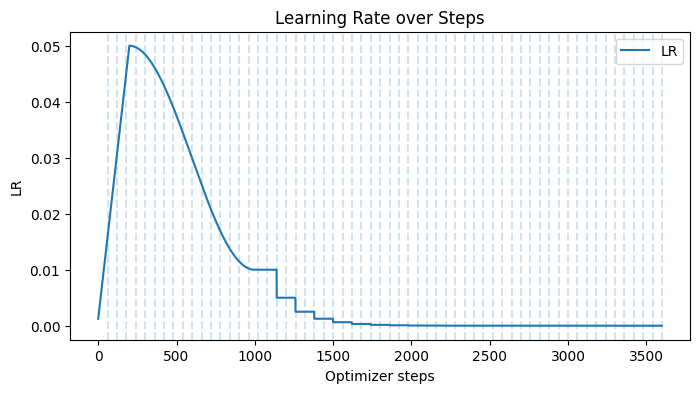

In [35]:
import matplotlib.pyplot as plt

def simulate_and_plot_lrs(optimizer, scheduler, steps_per_epoch, num_epochs, metric_trajectory="plateau"):
    """
    metric_trajectory:
      - "plateau": improves first few epochs then stagnates
      - "improving": keeps improving (no LR drop on plateau)
      - "worsening": gets worse (forces LR to drop when in plateau)
    """
    lrs, marks = [], []
    best = 1.0
    for epoch in range(num_epochs):
        # pretend training
        for _ in range(steps_per_epoch):
            optimizer.step()
            scheduler.step()
            lrs.append(scheduler.get_last_lr()[0])
        # pretend validation metric
        if metric_trajectory == "plateau":
            metric = best if epoch >= 4 else best * (0.8 ** (epoch + 1))
        elif metric_trajectory == "improving":
            metric = best * (0.8 ** (epoch + 1))
        else:  # worsening
            metric = best * (1.05 ** (epoch + 1))
        scheduler.step_plateau(metric)
        marks.append(len(lrs))  # end-of-epoch marker

    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(lrs, label="LR")
    for m in marks:
        plt.axvline(m, linestyle="--", alpha=0.2)
    plt.title("Learning Rate over Steps")
    plt.xlabel("Optimizer steps")
    plt.ylabel("LR")
    plt.legend()
    plt.show()

# Example (toy):
model = nn.Linear(128, 10)
opt2 = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
sched2 = WarmupAnnealThenPlateau(
    opt2,
    total_epochs=10, steps_per_epoch=100,
    pct_start=0.2,
    start_lr=1e-3, max_lr=0.05, base_lr=0.01,
    anneal_strategy="cos",
    plateau_mode="min",
    plateau_factor=0.5,
    plateau_patience=1,
    plateau_min_lr=1e-6,
)
simulate_and_plot_lrs(opt2, sched2, steps_per_epoch=60, num_epochs=60, metric_trajectory="plateau")

In [42]:
import torch
import math
from torch.optim.lr_scheduler import _LRScheduler
import matplotlib.pyplot as plt

class WarmupCosineAnnealScheduler(_LRScheduler):
    """
    Custom LR scheduler with a warm-up phase followed by a cosine annealing phase.
    
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        max_lr (float): Upper learning rate boundary after warmup.
        total_steps (int): Total number of steps for the entire schedule.
        pct_start (float): The percentage of total_steps to use for warmup.
        base_lr (float, optional): The final learning rate after annealing. Default: 0.
        div_factor (float, optional): Determines the initial learning rate via initial_lr = max_lr / div_factor. Default: 25.
        last_epoch (int, optional): The index of last epoch. Default: -1.
    """
    def __init__(self, optimizer, max_lr, total_steps, pct_start, base_lr=0., div_factor=25., last_epoch=-1):
        self.max_lr = max_lr
        self.total_steps = total_steps
        self.warmup_steps = int(total_steps * pct_start)
        self.anneal_steps = total_steps - self.warmup_steps
        self.initial_lr = max_lr / div_factor
        self.base_lr = base_lr
        super(WarmupCosineAnnealScheduler, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        # self.last_epoch is the current step counter
        current_step = self.last_epoch

        if current_step < self.warmup_steps:
            # Linear warmup phase
            scale = current_step / self.warmup_steps
            lr = self.initial_lr + (self.max_lr - self.initial_lr) * scale
        else:
            # Cosine annealing phase
            step_in_anneal = current_step - self.warmup_steps
            scale = 0.5 * (1 + math.cos(math.pi * step_in_anneal / self.anneal_steps))
            lr = self.base_lr + (self.max_lr - self.base_lr) * scale

        return [lr for _ in self.optimizer.param_groups]

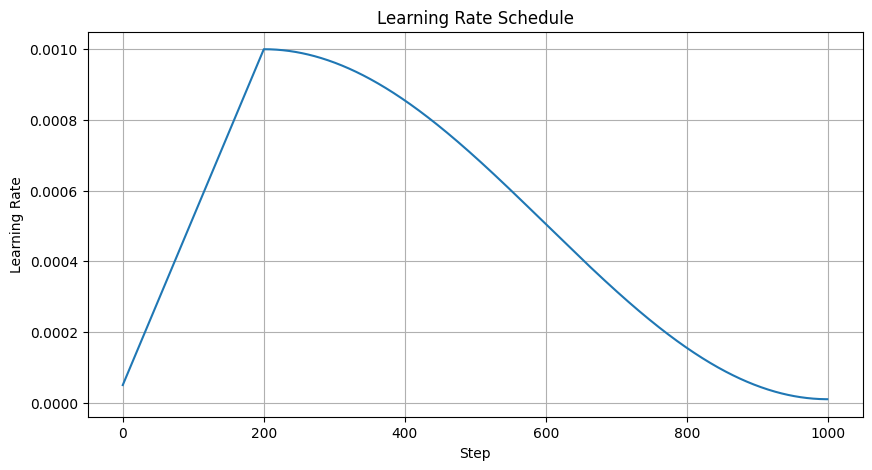

In [43]:
def plot_scheduler_lrs(scheduler, total_steps, title="Learning Rate Schedule"):
    """
    Plots the learning rate of a scheduler over a given number of steps.
    """
    # Dummy optimizer for simulation
    dummy_model = torch.nn.Linear(1, 1)
    optimizer = torch.optim.Adam(dummy_model.parameters(), lr=1.0) # Initial LR doesn't matter
    
    # Re-assign the scheduler to the dummy optimizer
    scheduler.optimizer = optimizer
    scheduler.last_epoch = -1 # Reset scheduler state
    
    lrs = []
    for _ in range(total_steps):
        # The scheduler's step must be called before the optimizer's step
        scheduler.step()
        lrs.append(optimizer.param_groups[0]['lr'])

    plt.figure(figsize=(10, 5))
    plt.plot(range(total_steps), lrs)
    plt.xlabel("Step")
    plt.ylabel("Learning Rate")
    plt.title(title)
    plt.grid(True)
    plt.show()

# --- Example Usage ---

# Define a dummy model and optimizer
model = torch.nn.Linear(10, 2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # Initial LR is overwritten by scheduler

# Scheduler parameters
TOTAL_STEPS = 1000
PCT_START = 0.2
MAX_LR = 1e-3
BASE_LR = 1e-5
DIV_FACTOR = 20

# Instantiate the scheduler
my_scheduler = WarmupCosineAnnealScheduler(
    optimizer,
    max_lr=MAX_LR,
    total_steps=TOTAL_STEPS,
    pct_start=PCT_START,
    base_lr=BASE_LR,
    div_factor=DIV_FACTOR
)

# Plot the learning rate schedule
plot_scheduler_lrs(my_scheduler, TOTAL_STEPS)

In [44]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.01
    lr: 5e-05
    maximize: False
    weight_decay: 0
)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [45]:
optimizer = optim.AdamW(model.parameters())

In [46]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.01
)